In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class LoadMatfiles:
    
    
    def __init__(self, ParityCheckMatrixDirection, DestinationFile):
        self.ParityCheckMatrixDirection = ParityCheckMatrixDirection
        self.DestinationFile = DestinationFile

        
        
    # This function, firstly, convert the .Mat file to .txt file,then generat prity check matrix H
    def LoadMatfile(self):

        pattern = re.compile(r"(\[\[|\],|\[|\]])")

        filename = self.ParityCheckMatrixDirection
        with open(filename, "r") as file:

            file = file.read()
            newfile = pattern.sub(r"", file)
        
        with open(self.DestinationFile, "w") as f:
            f.write(newfile)
        f.close()

        ParityCheckMatrix = pd.read_csv(
            self.DestinationFile,
            comment="%",
            header=None,
            sep=",",
            skip_blank_lines=True,
            na_filter=False,
        )

        ParityCheckMatrix = np.array(ParityCheckMatrix)
        return ParityCheckMatrix

In [ ]:
class InitializationProcess(LoadMatfiles):
    
    
    def __init__(self, ParityCheckMatrix, ReceivedVector, channel = 'AWGN' , Crossover_or_SNR=1.25):
        self.ParityCheckMatrix = ParityCheckMatrix
        self.ReceivedVector =ReceivedVector
        self.channel = channel
        self.Crossover_or_SNR = Crossover_or_SNR


        
    
    def NoneZeros(self):
    
        SetBitsInParities = {f'{i}': set(np.nonzero(self.ParityCheckMatrix[i,:])[0].astype(int))
                            for i in np.arange(0,np.shape(self.ParityCheckMatrix)[0])}

        SetParitiesForBits = {f'{j}': set(np.nonzero(self.ParityCheckMatrix[:,j])[0].astype(int))
                            for j in np.arange(0,np.shape(self.ParityCheckMatrix)[1])}

        return SetBitsInParities, SetParitiesForBits
    
    
    
    def Initialization(self, SetBitsInParities, SetParitiesForBits):
    
#         print('Please select your desired channel')
#         print('Enter AWGN For additive white Gaussian noise')
#         print('Enter BSC For additive binary symmetric channel')


#         channel = input('AWGN or BSC?:  ')
#         print('\n')

        if self.channel == 'BSC':

#             print('Enter crossover probability.')
#             p = float(input('Crossover probability p:  '))
#             print('\n')

            p = self.Crossover_or_SNR


            PrioriMProb =np.zeros((np.shape(self.ReceivedVector)))
            
            for i in np.arange(0,np.shape(self.ReceivedVector)[1]):
                if self.ReceivedVector[0,i] == 1:
                    PrioriMProb[0,i]= (np.log(p/(1-p)))
                else:
                    PrioriMProb[0,i]= (np.log((1-p)/p))


#             print('Priori Log-Likelihood Ratios: ')
#             print('PLLRs:', PrioriMProb)
#             print('\n')

        elif self.channel =='AWGN':

#             print('Enter noise variance.')
#             SNR = float(input('Noise variance SNR:  '))
#             print('\n')
            SNR = self.Crossover_or_SNR


            r = [4*self.ReceivedVector[0,i]*SNR for i in np.arange(0,np.shape(self.ReceivedVector)[1]) ]
            PrioriMProb = np.array([r])

#             print('Priori Log-Likelihood Ratios: ')
#             print('PLLRs:', PrioriMProb)
#             print('\n')


        PrioriMBitToCheck =np.zeros(np.shape(self.ParityCheckMatrix))

        for key in SetParitiesForBits.keys():
            for i in SetParitiesForBits[f'{key}']:
                PrioriMBitToCheck[int(i),int(key)]= PrioriMProb[0,int(key)]
        
#         print('PrioriMBitToCheck= ')
#         print(PrioriMBitToCheck)
#         print('\n')

        return PrioriMBitToCheck, PrioriMProb



In [ ]:
import pandas as pd
import numpy as np
import re

ParityCheckMatrixDirection = "/content/drive/My Drive/Colab Notebooks/Code1_MinDis8_Girth6_Dimen56_Rate0518_Length108"
DestinationFile = "/content/drive/My Drive/Colab Notebooks/newfile1.txt"
decoding = LoadMatfiles(ParityCheckMatrixDirection, DestinationFile )

ParityCheckMatrix = decoding.LoadMatfile()

ParityCheckMatrix = ParityCheckMatrix[0:54,:]


In [ ]:
print(np.shape(ParityCheckMatrix))

(54, 108)


In [ ]:
def ExtrinsicMessages(MBitToCheck, SetBitsInParities):
    
    ExtInfo = np.zeros(np.shape(MBitToCheck))
    
    for key in SetBitsInParities.keys():
        for BitV in SetBitsInParities[f'{key}']:
            Pt = 1
            for j in SetBitsInParities[f'{key}']:
                if j != BitV:
                    Pt *= np.tanh(MBitToCheck[int(key), int(j)]/2)
            ExtInfo[int(key), int(BitV)] = np.log((1+(0.9*Pt))/(1-(0.9*Pt)))
            
    return ExtInfo


In [ ]:
def TotalLLRs(ExtrinsicInfo, PriorLLRs, SetParitiesForBits):
    
    TLLRs = np.zeros(np.shape(PriorLLRs))
    
    for key in SetParitiesForBits.keys():
        TLLR = 0
        for i in SetParitiesForBits[f'{key}']:
            TLLR += ExtrinsicInfo[int(i),int(key)]
        TLLRs[0,int(key)] = TLLR + PriorLLRs[0,int(key)]
        
    return TLLRs

In [ ]:
def HardDecision(TLLRs):
    CodeWord = np.zeros(np.shape(TLLRs)).astype(int)
    sgn = np.sign(TLLRs)
    for i in range(0,np.shape(TLLRs)[1]):
        if sgn[0,i] == -1:
            CodeWord[0,i] = 1 
            
    return CodeWord

In [ ]:
def CodeWordValidation(ParityCheckMatrix, CodeWord):
    if np.all((np.dot(CodeWord, np.transpose(ParityCheckMatrix))%2 == 0)):
        return True
    else:
        return False
        
    

In [ ]:
def MBitToCheck(ExtrinsicInfo, SetParitiesForBits, PriorLLRs):
    
    BitToCheckInfo = np.zeros(np.shape(ExtrinsicInfo))
    
    for key in SetParitiesForBits.keys():
        for val in SetParitiesForBits[f'{key}']:
            Mes = 0
            for i in SetParitiesForBits[f'{key}']:
                if i != val:
                    Mes += ExtrinsicInfo[int(i),int(key)]
                    
            
            BitToCheckInfo[int(val),int(key)] = Mes +  PriorLLRs[0, int(key)]
    
    
    return BitToCheckInfo
    
    

In [ ]:
def SumProduct(ParityCheckMatrix,  ReceivedVector, channel = 'AWGN', Crossover_or_SNR=1.25):
    
    #Initialization 
    
    init =InitializationProcess(ParityCheckMatrix,ReceivedVector,channel, Crossover_or_SNR)
    
    SetBitsInParities, SetParitiesForBits = init.NoneZeros()
    BitToCheckInfo, PriorLLRs = init.Initialization(SetBitsInParities, SetParitiesForBits)
    
    
#     print('\n')
    
    Itr = 1
    while True:
        
        ExtrinsicInfo= ExtrinsicMessages(BitToCheckInfo, SetBitsInParities)
        
#         print('Iteration:  ', Itr)
#         print('ExtrinsicInfo: ')
#         print(ExtrinsicInfo)
#         print('\n')
        
        
        TLRRs = TotalLLRs(ExtrinsicInfo, PriorLLRs, SetParitiesForBits)
        
#         print("TotalLLRs: ")
#         print(TLRRs)
#         print('\n')
        
        
        CodeWord = HardDecision(TLRRs)
        
#         print("CodeWord")
#         print(CodeWord)
#         print('\n')
        
        if Itr >= 100:
            return CodeWord
            break
        elif  CodeWordValidation(ParityCheckMatrix, CodeWord)== True:
#             print('True Code word:')
#             print(CodeWord)
            return CodeWord
            break
            
        
        
        BitToCheckInfo = MBitToCheck(ExtrinsicInfo, SetParitiesForBits, PriorLLRs)
        Itr += 1
        
#         print('BitToCheckInfo: ')
#         print(BitToCheckInfo)
#         print('\n')
        

In [ ]:
#BPSK BER


def BPSK_AWGN_Simulation(ParityCheckMatrix ,MinSNR , MaxSNR, CodeRate, CodeLength=100000,  MaxIteration=1000):
    
    SNR = np.array([np.arange(MinSNR, MaxSNR+1 , 0.5)])
    BER = []
    FER = []
    for snr in np.arange(MinSNR, MaxSNR+1, 0.5):
        
        snr = 10**(0.1*snr)
        NoiseVar = 1/(2*CodeRate*snr)
        itr = 0; Error = 0; FError =0
        
        while True:
            
#             Message = np.array([np.random.randint(2, size=CodeLength)])
            Message = np.zeros((1, CodeLength))
            BPSKModulation = 1-2*Message
            #print(np.shape(Message))
            
            RandomVector = np.random.normal(0,NoiseVar, size=CodeLength)
            ReceivedVector = BPSKModulation + RandomVector
            
#             mess_cap = [(-np.sign(i)+1)/2 for i in RecievedMess]
#             mess_cap =np.array(mess_cap).astype(int)
            mess_cap= SumProduct(ParityCheckMatrix, 
                                 ReceivedVector, channel = 'AWGN',
                                 Crossover_or_SNR= snr)
            
            
            NoneEquales = np.sum(mess_cap != Message)
            Error += NoneEquales
            itr += 1
            



            if NoneEquales >= 1:
                FError +=1


            if FError >= 30: 
                break
                
            
            
        BER.append(Error/(CodeLength*itr))
        FER.append(FError/itr)

        
        
    return SNR, np.array([BER]), np.array([FER])
    

In [ ]:
SNR, BER, FER = BPSK_AWGN_Simulation(ParityCheckMatrix ,
                                MinSNR=0 , MaxSNR=3,
                                CodeRate=(1/2),
                                CodeLength=108,
                                MaxIteration=1000
                               )
print('BER: \n', BER)
print('FER: \n', FER)

BER: 
 [[1.20370370e-01 7.36331570e-02 2.89855072e-02 9.20604513e-03
  1.27200220e-03 2.59748197e-04 3.38237781e-05 5.99759548e-06]]
FER: 
 [[8.82352941e-01 7.14285714e-01 4.34782609e-01 1.72413793e-01
  3.71287129e-02 1.23762376e-02 1.95694716e-03 5.55205981e-04]]


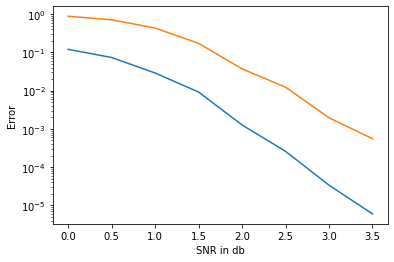

In [ ]:
import matplotlib.pyplot as plt


plt.semilogy(SNR[0,:], BER[0,:], label= 'BER')
plt.semilogy(SNR[0,:], FER[0,:], label='FER')
plt.xlabel('SNR in db')
plt.ylabel("Error")
# plt.semilogy(SNR[0,:], FER[0,:])
plt.show()

